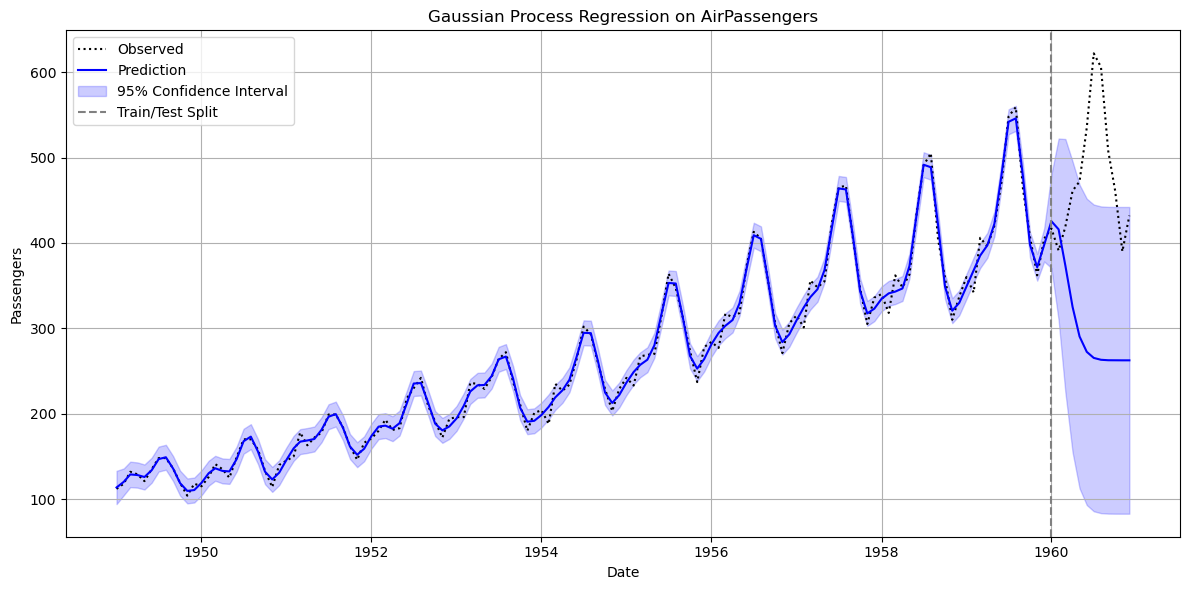

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Load your CSV file
# Replace 'AirPassengers.csv' with the correct path if needed
df = pd.read_csv('airplane-passengers.csv')

# Ensure correct column names
# If necessary, rename columns to standardize
if 'Month' not in df.columns:
    df.rename(columns={df.columns[0]: 'Month'}, inplace=True)
if 'Passengers' not in df.columns:
    df.rename(columns={df.columns[1]: 'Passengers'}, inplace=True)

# Convert Month to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Prepare data
y = df['Passengers'].values.reshape(-1, 1)
X = np.arange(len(y)).reshape(-1, 1)

# Train-test split (last 12 months as test)
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

# Define Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=10.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True, n_restarts_optimizer=10)
gpr.fit(X_train, y_train)

# Predict on full range
X_all = np.vstack((X_train, X_test))
y_pred, sigma = gpr.predict(X_all, return_std=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, y, 'k:', label='Observed')
plt.plot(df.index, y_pred, 'b-', label='Prediction')
plt.fill_between(df.index,
                 y_pred.ravel() - 1.96 * sigma,
                 y_pred.ravel() + 1.96 * sigma,
                 color='blue', alpha=0.2, label='95% Confidence Interval')
plt.axvline(df.index[-12], color='gray', linestyle='--', label='Train/Test Split')
plt.title('Gaussian Process Regression on AirPassengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


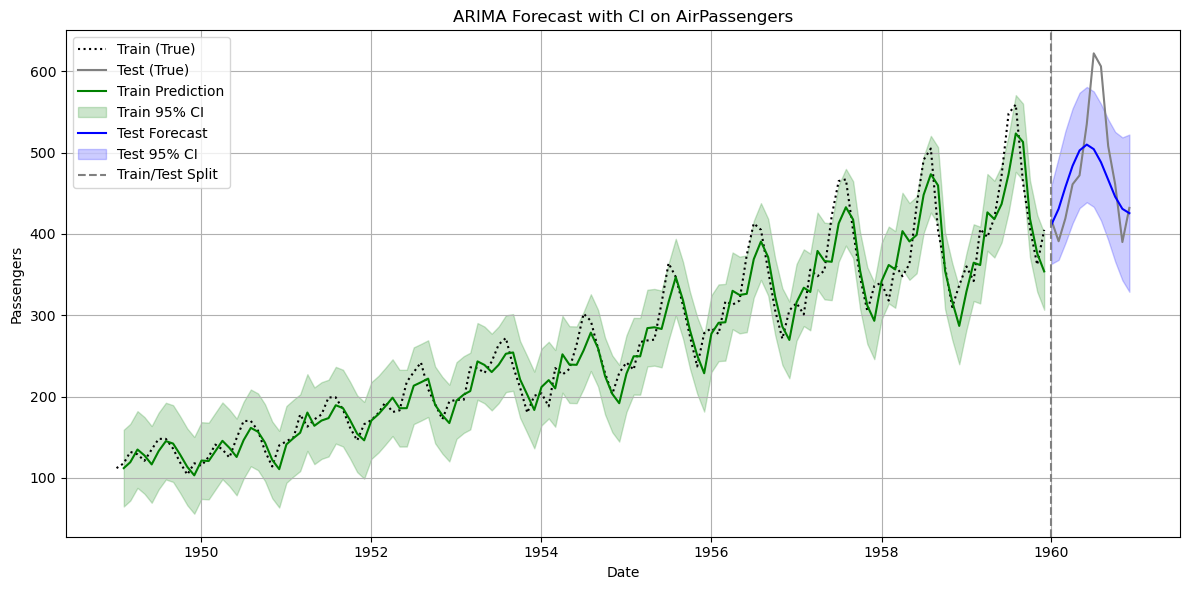

In [4]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Split data
train = df.iloc[:-12]
test = df.iloc[-12:]

# Fit ARIMA model to training data
model = ARIMA(train['Passengers'], order=(2, 1, 2))
model_fit = model.fit()

# In-sample prediction
train_pred = model_fit.predict(start=train.index[1], end=train.index[-1], typ='levels')

# Residual standard deviation (for CI approximation)
residuals = train['Passengers'].iloc[1:] - train_pred
sigma_train = np.std(residuals)

# CI for training prediction (approximate, ±1.96 * std)
train_lower = train_pred - 1.96 * sigma_train
train_upper = train_pred + 1.96 * sigma_train

# Forecast for test period
forecast_result = model_fit.get_forecast(steps=12)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Plot
plt.figure(figsize=(12, 6))

# Ground truth
plt.plot(train.index, train['Passengers'], label='Train (True)', color='black', linestyle=':')
plt.plot(test.index, test['Passengers'], label='Test (True)', color='gray')

# Predictions
plt.plot(train_pred.index, train_pred, label='Train Prediction', color='green')
plt.fill_between(train_pred.index, train_lower, train_upper,
                 color='green', alpha=0.2, label='Train 95% CI')

plt.plot(test.index, forecast_mean, label='Test Forecast', color='blue')
plt.fill_between(test.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='blue', alpha=0.2, label='Test 95% CI')

# Split marker
plt.axvline(test.index[0], color='gray', linestyle='--', label='Train/Test Split')

# Final touches
plt.title('ARIMA Forecast with CI on AirPassengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


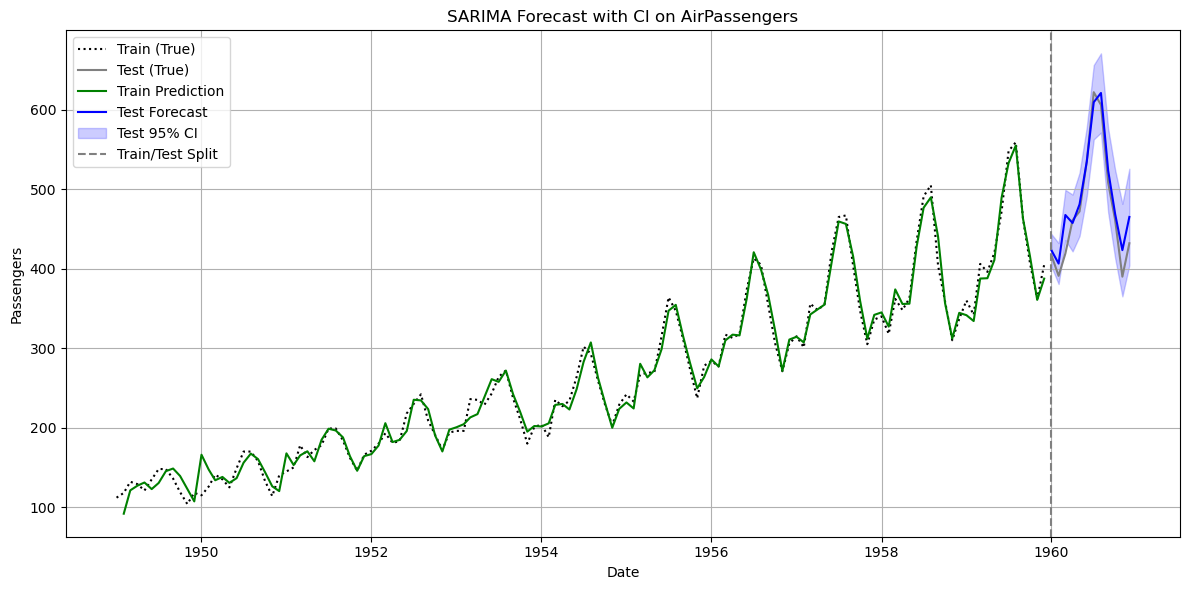

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Split data
train = df.iloc[:-12]
test = df.iloc[-12:]

# Fit SARIMA model
model = SARIMAX(train['Passengers'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

# In-sample prediction
train_pred = model_fit.get_prediction(start=train.index[1], end=train.index[-1], dynamic=False)
train_mean = train_pred.predicted_mean
train_ci = train_pred.conf_int()

# Forecast for test period
forecast_result = model_fit.get_forecast(steps=12)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Plot
plt.figure(figsize=(12, 6))

# Ground truth
plt.plot(train.index, train['Passengers'], label='Train (True)', color='black', linestyle=':')
plt.plot(test.index, test['Passengers'], label='Test (True)', color='gray')

# In-sample prediction with CI
plt.plot(train_mean.index, train_mean, label='Train Prediction', color='green')
#plt.fill_between(train_ci.index,
#                 train_ci.iloc[:, 0],
#                 train_ci.iloc[:, 1],
#                 color='green', alpha=0.2, label='Train 95% CI')

# Forecast with CI
plt.plot(test.index, forecast_mean, label='Test Forecast', color='blue')
plt.fill_between(test.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='blue', alpha=0.2, label='Test 95% CI')

# Train/Test Split marker
plt.axvline(test.index[0], color='gray', linestyle='--', label='Train/Test Split')

# Final touches
plt.title('SARIMA Forecast with CI on AirPassengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


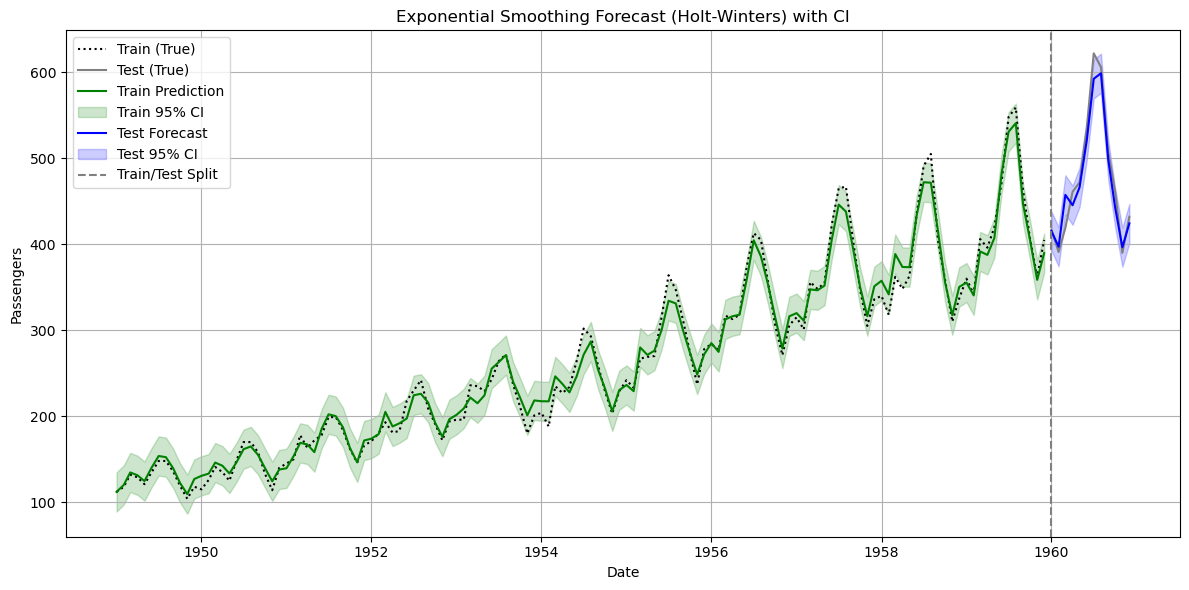

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Split data
train = df.iloc[:-12]
test = df.iloc[-12:]

# Fit the model with additive trend and seasonality (monthly = 12)
model = ExponentialSmoothing(
    train['Passengers'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
)
model_fit = model.fit()

# Predict on training
train_pred = model_fit.fittedvalues

# Residuals and CI estimation for training
residuals = train['Passengers'] - train_pred
sigma_train = np.std(residuals)
train_lower = train_pred - 1.96 * sigma_train
train_upper = train_pred + 1.96 * sigma_train

# Forecast for the test set
forecast = model_fit.forecast(steps=12)
forecast_index = test.index
forecast_lower = forecast - 1.96 * sigma_train
forecast_upper = forecast + 1.96 * sigma_train

# Plot
plt.figure(figsize=(12, 6))

# Actual data
plt.plot(train.index, train['Passengers'], label='Train (True)', color='black', linestyle=':')
plt.plot(test.index, test['Passengers'], label='Test (True)', color='gray')

# Predictions
plt.plot(train.index, train_pred, label='Train Prediction', color='green')
plt.fill_between(train.index, train_lower, train_upper,
                 color='green', alpha=0.2, label='Train 95% CI')

plt.plot(forecast_index, forecast, label='Test Forecast', color='blue')
plt.fill_between(forecast_index, forecast_lower, forecast_upper,
                 color='blue', alpha=0.2, label='Test 95% CI')

# Train/Test Split
plt.axvline(test.index[0], color='gray', linestyle='--', label='Train/Test Split')

# Final touches
plt.title('Exponential Smoothing Forecast (Holt-Winters) with CI')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


22:11:48 - cmdstanpy - INFO - Chain [1] start processing
22:11:48 - cmdstanpy - INFO - Chain [1] done processing


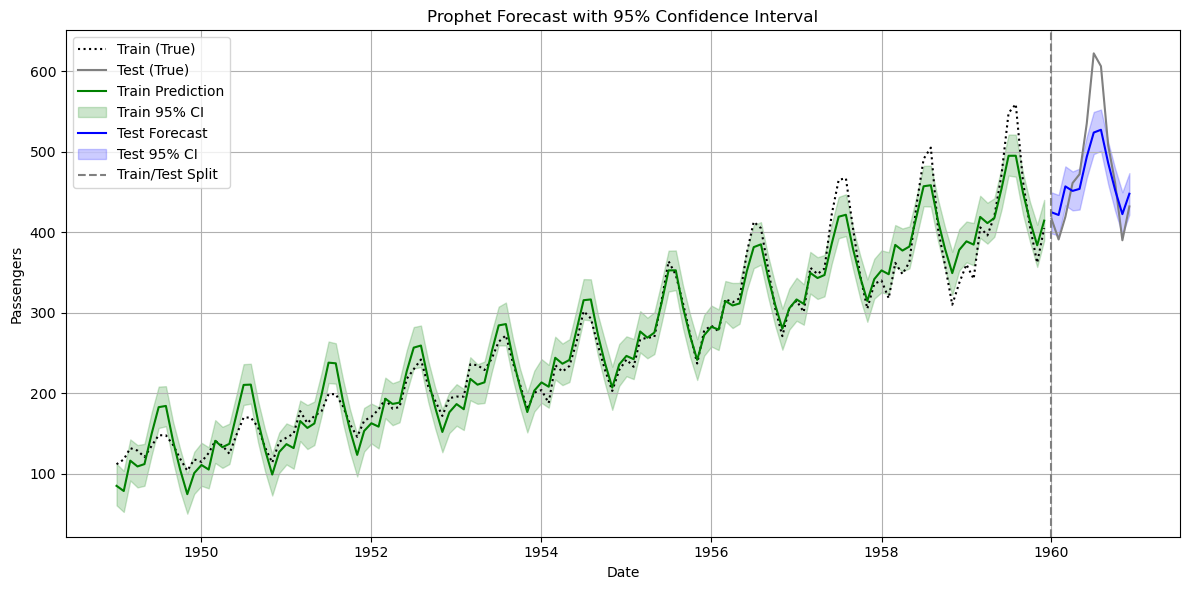

In [7]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Prepare Prophet input
prophet_df = df.reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})
train_df = prophet_df.iloc[:-12]
test_df = prophet_df.iloc[-12:]

# Fit model
model = Prophet(yearly_seasonality=True)
model.fit(train_df)

# Create custom future with month start dates
future_dates = pd.date_range(start=train_df['ds'].max() + pd.DateOffset(months=1),
                             periods=12, freq='MS')  # 'MS' = month start
future = pd.concat([train_df['ds'], future_dates.to_series()], ignore_index=True).to_frame(name='ds')

# Predict
forecast = model.predict(future)

# Align predictions
train_pred = forecast[forecast['ds'].isin(train_df['ds'])]
test_pred = forecast[forecast['ds'].isin(test_df['ds'])]

# Plot
plt.figure(figsize=(12, 6))

# Ground truth
plt.plot(train_df['ds'], train_df['y'], label='Train (True)', color='black', linestyle=':')
plt.plot(test_df['ds'], test_df['y'], label='Test (True)', color='gray')

# Train predictions with CI
plt.plot(train_pred['ds'], train_pred['yhat'], label='Train Prediction', color='green')
plt.fill_between(train_pred['ds'],
                 train_pred['yhat_lower'],
                 train_pred['yhat_upper'],
                 color='green', alpha=0.2, label='Train 95% CI')

# Test predictions with CI
plt.plot(test_pred['ds'], test_pred['yhat'], label='Test Forecast', color='blue')
plt.fill_between(test_pred['ds'],
                 test_pred['yhat_lower'],
                 test_pred['yhat_upper'],
                 color='blue', alpha=0.2, label='Test 95% CI')

# Train/Test split marker
plt.axvline(test_df['ds'].iloc[0], color='gray', linestyle='--', label='Train/Test Split')

# Finalize plot
plt.title('Prophet Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/edsonodake/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


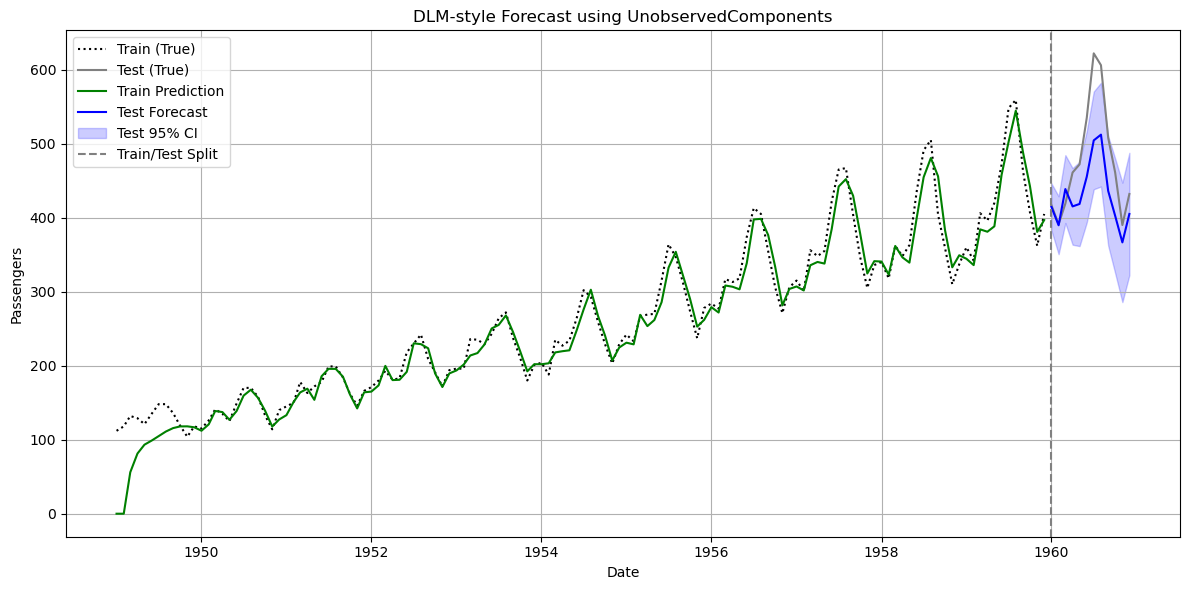

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Split
train = df.iloc[:-12]
test = df.iloc[-12:]

# Define model (local level + seasonal = classic DLM structure)
model = UnobservedComponents(train['Passengers'],
                             level='local level',
                             seasonal=12)

# Fit
model_fit = model.fit(disp=False)

# In-sample prediction + CI
train_pred = model_fit.get_prediction()
train_mean = train_pred.predicted_mean
train_ci = train_pred.conf_int()

# Forecast
forecast = model_fit.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))

# Actual data
plt.plot(train.index, train['Passengers'], label='Train (True)', linestyle=':', color='black')
plt.plot(test.index, test['Passengers'], label='Test (True)', color='gray')

# In-sample prediction
plt.plot(train.index, train_mean, label='Train Prediction', color='green')
#plt.fill_between(train.index,
#                 train_ci.iloc[:, 0],
#                 train_ci.iloc[:, 1],
#                 color='green', alpha=0.2, label='Train 95% CI')

# Forecast
plt.plot(test.index, forecast_mean, label='Test Forecast', color='blue')
plt.fill_between(test.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='blue', alpha=0.2, label='Test 95% CI')

# Split marker
plt.axvline(test.index[0], linestyle='--', color='gray', label='Train/Test Split')

# Final polish
plt.title('DLM-style Forecast using UnobservedComponents')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Forecasting Models with Confidence Intervals

This notebook compares several time series forecasting models, each capable of providing **point forecasts** and **confidence intervals (CI)**. Below is a summary of the implemented models:

---

## 1. ARIMA (AutoRegressive Integrated Moving Average)

- **Type**: Statistical
- **CI**: Built-in
- **Best for**: Data with trend, no clear seasonality.
- **Highlights**: Captures autoregression and moving average behavior, requires manual order tuning (p, d, q).

---

## 2. SARIMA (Seasonal ARIMA)

- **Type**: Statistical
- **CI**: Built-in
- **Best for**: Data with both trend and seasonality.
- **Highlights**: Extends ARIMA by modeling seasonal cycles. Confidence intervals may be unstable in early time steps due to differencing.

---

## 3. Holt-Winters (Exponential Smoothing)

- **Type**: Statistical
- **CI**: Approximated (via residual std. dev)
- **Best for**: Smooth seasonal data with trend.
- **Highlights**: Simple, interpretable model. Uses additive or multiplicative components.

---

## 4. Prophet (Meta/Facebook)

- **Type**: Bayesian Structural Time Series (BSTS)
- **CI**: Built-in (posterior intervals)
- **Best for**: Business time series, trend shifts, holidays.
- **Highlights**: Combines trend + seasonality + holidays. Automatically handles missing data, outliers, and changepoints.

---

## 5. Gaussian Process Regression (GPR)

- **Type**: Non-parametric Bayesian
- **CI**: Built-in
- **Best for**: Interpolation tasks or short-term forecasting with smooth patterns.
- **Highlights**: Captures uncertainty explicitly via posterior variance. Poor for long-range extrapolation unless seasonal features are added.

---

## 6. Dynamic Linear Model (DLM) – via `statsmodels.UnobservedComponents`

- **Type**: State Space / Frequentist DLM
- **CI**: Built-in
- **Best for**: Decomposable models with trend and seasonality.
- **Highlights**: General-purpose structural model with components like local level, trend, and seasonal effects.

---

## 7. TensorFlow Probability – Structural Time Series (`tfp.sts`)

- **Type**: Full Bayesian Structural Time Series
- **CI**: Built-in (posterior predictive samples)
- **Best for**: Advanced modeling with full control over priors, components, and inference.
- **Highlights**: Implements latent trend + seasonality using variational inference. Scalable and highly customizable.

---
